In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the dataset
file_path = "../data/combined_data.csv"
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure
df.head()


,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation
0,0,2033.00,55.31,55.130,54.9484,55.1524,27.307067,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0
1,1,2033.02,55.17,55.255,54.9588,55.1654,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0
2,2,2033.04,55.03,55.380,54.9626,55.1838,27.323949,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0
3,3,2033.06,55.04,55.430,54.9658,55.2046,27.319727,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0
4,4,2033.08,55.05,55.480,54.9726,55.2198,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0


In [3]:
# Convert speeds from km/h to m/s
df["v_follower"] = df["Smooth Speed Follower"] * (1000 / 3600)
df["v_leader"] = df["Smooth Speed Leader"] * (1000 / 3600)

# Calculate time difference (in seconds)
df["dt"] = df["Time"].diff()

# Estimate acceleration using forward difference: a(t) = [v(t+1) - v(t)] / dt
df["acc_follower"] = df["v_follower"].diff() / df["dt"]

# Drop the first row with NaN (from diff)
df_cleaned = df.dropna(subset=["dt", "acc_follower"])

df_cleaned.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader,dt,acc_follower
1,1,2033.02,55.170,55.255,54.9588,55.1654,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.266333,15.323722,0.02,0.144444
2,2,2033.04,55.030,55.380,54.9626,55.1838,27.323949,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.267389,15.328833,0.02,0.052778
3,3,2033.06,55.040,55.430,54.9658,55.2046,27.319727,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.268278,15.334611,0.02,0.044444
4,4,2033.08,55.050,55.480,54.9726,55.2198,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.270167,15.338833,0.02,0.094444
5,5,2033.10,55.005,55.340,54.9808,55.2218,27.324214,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.272444,15.339389,0.02,0.113889


In [4]:
from scipy.optimize import minimize

In [5]:


# Extract relevant columns as NumPy arrays
v_follower = df_cleaned["v_follower"].values
v_leader = df_cleaned["v_leader"].values
spacing = df_cleaned["Spacing"].values
delta_v = v_follower - v_leader
acc_observed = df_cleaned["acc_follower"].values

# IDM acceleration function
def idm_acceleration(v, s, delta_v, a, v0, T, s0, b, delta=4):
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
    acc = a * (1 - (v / v0) ** delta - (s_star / s) ** 2)
    return acc

# Loss function: Mean Squared Error between observed and IDM-predicted acceleration
def loss_idm(params):
    a, v0, T, s0, b = params
    acc_pred = idm_acceleration(v_follower, spacing, delta_v, a, v0, T, s0, b)
    return np.mean((acc_pred - acc_observed) ** 2)

# Initial guess for parameters: [a, v0, T, s0, b]
initial_guess = [1.0, 30.0, 1.5, 2.0, 1.5]

# Parameter bounds to keep values physically realistic
bounds = [(0.1, 5),    # a
          (5, 50),     # v0
          (0.5, 3),    # T
          (0.5, 5),    # s0
          (0.1, 5)]    # b

# Run the optimization
result = minimize(loss_idm, initial_guess, bounds=bounds, method='L-BFGS-B')

# Extract optimized parameters
optimized_params = result.x
optimized_params


array([ 0.45711081, 50.        ,  1.14716372,  5.        ,  0.80499389])

In [6]:
a_opt, v0_opt, T_opt, s0_opt, b_opt = result.x

In [7]:

import matplotlib.pyplot as plt
# Simulate using optimized IDM parameters
time = df_cleaned["Time"].values
dt = df_cleaned["dt"].values[0]
n = len(time)
v_sim = np.zeros(n)
x_sim = np.zeros(n)
x_leader = np.zeros(n)

v_sim[0] = v_follower[0]
x_sim[0] = 0
x_leader[0] = spacing[0]

for i in range(1, n):
    x_leader[i] = x_leader[i-1] + v_leader[i-1] * dt
    s = x_leader[i-1] - x_sim[i-1]
    delta_v = v_sim[i-1] - v_leader[i-1]
    acc = idm_acceleration(v_sim[i-1], s, delta_v, a_opt, v0_opt, T_opt, s0_opt, b_opt)
    v_sim[i] = max(v_sim[i-1] + acc * dt, 0)
    x_sim[i] = x_sim[i-1] + v_sim[i-1] * dt

spacing_sim = x_leader - x_sim




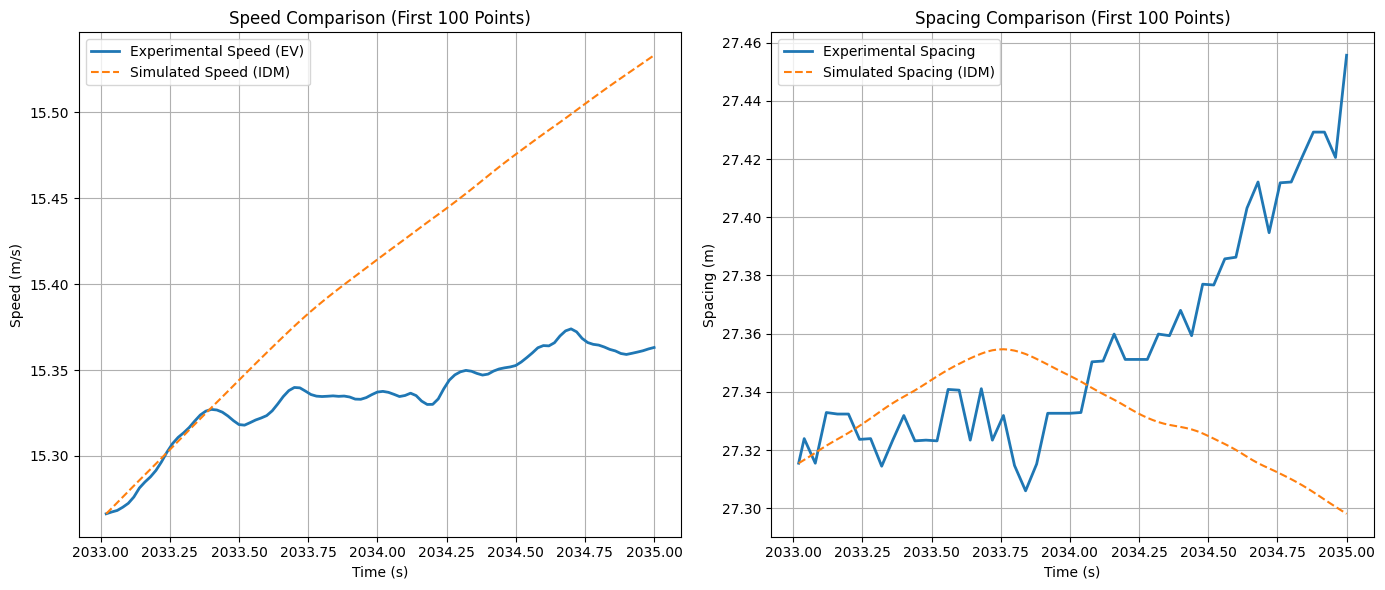

In [8]:
# Limit the plots to the first 100 data points
limit = 100
time_plot = time[:limit]
v_follower_plot = v_follower[:limit]
v_sim_plot = v_sim[:limit]
spacing_plot = spacing[:limit]
spacing_sim_plot = spacing_sim[:limit]

# Plot results for first 100 data points
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(time_plot, v_follower_plot, label='Experimental Speed (EV)', linewidth=2)
plt.plot(time_plot, v_sim_plot, label='Simulated Speed (IDM)', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.title("Speed Comparison (First 100 Points)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_plot, spacing_plot, label='Experimental Spacing', linewidth=2)
plt.plot(time_plot, spacing_sim_plot, label='Simulated Spacing (IDM)', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Spacing (m)")
plt.title("Spacing Comparison (First 100 Points)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
